C:\Users\ahmed\AppData\Local\Temp\ipykernel_8060\1610102571.py:27: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True)


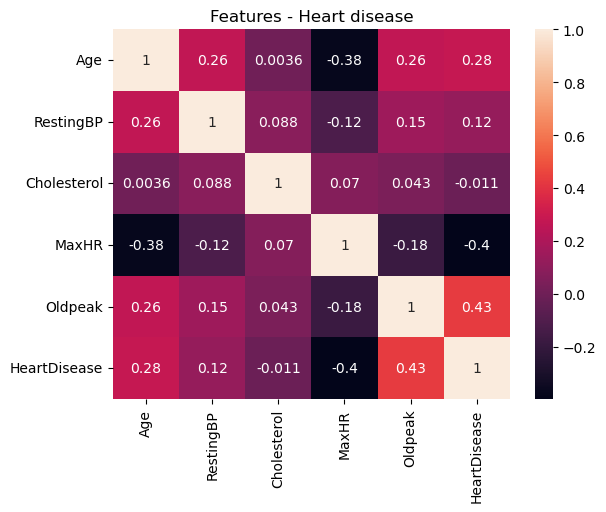

Training DecisionTreeClassifier
Accuracy score on test set: 0.8232044198895028
-------------------------
Training RandomForestClassifier
Accuracy score on test set: 0.8839779005524862
-------------------------
Training LogisticRegression
Accuracy score on test set: 0.8839779005524862
-------------------------
 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\ahmed\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
# This code will try to predict the posibility of getting a heart disease
# Based on a dataset of information about heart disease patients.

# Import necessary libraries 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score

# Here I will load the dataset from heart.csv
data = pd.read_csv('input/heart.csv')

# At this section I will do data cleanning, exploring and scaling
# Convert 'FastingBS' column to string type
data['FastingBS'] = data['FastingBS'].astype(str)
# Replace missing values in 'Cholesterol' and 'RestingBP' columns with the mean value
data['Cholesterol'] = data['Cholesterol'].replace(0, data['Cholesterol'].mean())
data['RestingBP'] = data['RestingBP'].replace(0, data['RestingBP'].mean())
# Remove rows where 'Oldpeak' column is less than 0
data = data[data['Oldpeak'] >= 0]


# Visualize correlation between features and target variable using heatmap
sns.heatmap(data.corr(), annot=True)
plt.title('Features - Heart disease')
plt.show()

# Prepare the data for training
heart_raw = data['HeartDisease']
features_raw = data.drop('HeartDisease', axis=1)
skewed = ['Cholesterol', 'Oldpeak']
features_log_transformed = pd.DataFrame(data=features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

scaler = StandardScaler()
numerical = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
features_log_minmax_transform = pd.DataFrame(data=features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

features_final = pd.get_dummies(features_log_minmax_transform)

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(features_final, heart_raw, test_size=0.2, random_state=0)



# Function to train the model
def train_predict(learner, X_train, y_train, X_test, y_test):
    learner.fit(X_train, y_train)
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    accuracy = accuracy_score(y_test, predictions_test)
    fbeta = fbeta_score(y_test, predictions_test, beta=0.5)
    return (accuracy, fbeta)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

tree = DecisionTreeClassifier(random_state=0)
forest = RandomForestClassifier(random_state=0)
lr = LogisticRegression(random_state=0)

for clf in [tree, forest, lr]:
    print(f"Training {clf.__class__.__name__}")
    acc, fbeta = train_predict(clf, X_train, y_train, X_test, y_test)
    print(f"Accuracy score on test set: {acc}")
    print("-" * 25)

    
    
    
# Create endpoint to get patient information and return a predicition about this patient in regards to heart diseases
from flask import Flask, request, jsonify
import pickle

app = Flask(__name__)

# We can use any trained model we trained before, here i used logistic regression 
model = lr
# model = tree
# model = forest


@app.route('/predict', methods=['POST'])
def predict():
    # Get the patient data
    data = request.get_json()

    # Preprocess the data
    age = data['age']
    sex = data['sex']
    cp = data['cp']
    trestbps = data['trestbps']
    chol = data['chol']
    fbs = data['fbs']
    restecg = data['restecg']
    thalach = data['thalach']
    exang = data['exang']
    oldpeak = data['oldpeak']
    slope = data['slope']
    ca = data['ca']
    thal = data['thal']

    # Make the prediction
    prediction = model.predict_proba([[age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal]])

    # Return the result
    return jsonify({'probability': prediction[0][1]})

if __name__ == '__main__':
    app.run(port=5000,debug=True)
